In [1]:
'''
*********************************************
this code produces (prediction) cloud-mask binary data products for a MISR image blocks that we used in SIR prediction.
*********************************************
steps:
load the model and use the trained model for prediction.
produce cloud-mask binary files.
then we use these cloud-mask binary files in the SIR.c code and predict the SIR 
and check if SIR predictions have improved

inputs: (9x red-band from all cameras @toa_refl_dir

output: predicted cloud-mask (binary file) for each MISR block @toa_refl_dir
*********************************************
reminder: 
class one: cloudy
class zero: clear
*********************************************
to-do later:
check file type of cloudmask inside SIR code; what format does input cloudmask file have in that code?
for-loop for the whole code
make a list of POB form all available toa-refls to keep count 

ok- extract POB fro toa-refl
ok- fillvalue from previous MISR cloudmasks?
ok- skip a pixel if there is [-1]?
ok- update the the predicted categorical list with fillvalue using indexing and assignment
*********************************************
? check 0,1 output in cloudmask output file; shoudl be binary, not float? 
>>> output cloudmask format is now [int8] [8 bits== range[-128,127]]; -2 is the fillvalue

? check format of this cloudmask as input file to the next code (atmmodel?) dtype= uint8? or int8?


then:
? run for a cloudy image and compare with baseline==visual conformation


finally- I need a code to read a cloudmask binary file and update the traning dataset for a specific cloudy block and then update the specific column for future comparison between my model and MISR cloudmasks


'''

'\n*********************************************\nthis code produces (prediction) cloud-mask binary data products for a MISR image blocks that we used in SIR prediction.\n*********************************************\nsteps:\nload the model and use the trained model for prediction.\nproduce cloud-mask binary files.\nthen we use these cloud-mask binary files in the SIR.c code and predict the SIR \nand check if SIR predictions have improved\n\ninputs: (9x red-band from all cameras @toa_refl_dir\n\noutput: predicted cloud-mask (binary file) for each MISR block @toa_refl_dir\n*********************************************\nreminder: \nclass one: cloudy\nclass zero: clear\n*********************************************\nto-do later:\ncheck file type of cloudmask inside SIR code; what format does input cloudmask file have in that code?\nfor-loop for the whole code\nmake a list of POB form all available toa-refls to keep count \n\nok- extract POB fro toa-refl\nok- fillvalue from previous MISR c

In [2]:
run_month = 'April'

write_nncm_binary = True
plot_nncm = True

In [3]:
import os
from glob import glob
import numpy as np
from keras.models import load_model
from matplotlib import pyplot as plt

In [4]:
# load input files for the model
# inputs: 9xTOA reflectance red bands- order is important

# model dir path
model_dir = "/Users/ehsanmos/MLP_dataset/cloudmask_lab/models_and_trainingDS/models_final"

# root directory where everything is there
root_dir = "/Users/ehsanmos/MLP_dataset/cloudmask_lab/predict_test_cloudmask/p71_o87048_b28_april"

In [5]:
# where toa-refl files are
toa_refl_dir = root_dir

# where to save output bin file
output_predict_dir = root_dir

# where to save plots
plot_dir = root_dir

## >>> do not change anything else <<<

In [6]:
# set path to model & directory

if (run_month == 'April'):
    model_name = "model_April_loss0.27_acc0.91.h5"

if (run_month == 'July'):
    model_name = "model_July_loss0.25_acc0.91.h5"
    
# check if model file is availabel
check_ret = os.path.isfile(os.path.join(model_dir, model_name))
if (not check_ret):
    print('model is not available!')
    raise SystemExit("program exited")
else:
    print('model was found!')

model was found!


### load the model for april/july

In [7]:
# set path to the model dir
model_fp = os.path.join(model_dir, model_name) 

# load model
mlp_model_best = load_model(model_fp)

# summarize model
mlp_model_best.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 2786 (10.88 KB)
Trainable params: 2786 (10.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# check toa-refl directory available

In [9]:
# get a list of toa_refl files

toa_refl_filePattern = "toa_refl_P*.dat"

toa_refl_list = glob(os.path.join(toa_refl_dir, toa_refl_filePattern))
print(len(toa_refl_list))


9


In [10]:
toa_refl_list

['/Users/ehsanmos/MLP_dataset/cloudmask_lab/predict_test_cloudmask/p71_o87048_b28_april/toa_refl_P071_O087048_B028_df_red.dat',
 '/Users/ehsanmos/MLP_dataset/cloudmask_lab/predict_test_cloudmask/p71_o87048_b28_april/toa_refl_P071_O087048_B028_aa_red.dat',
 '/Users/ehsanmos/MLP_dataset/cloudmask_lab/predict_test_cloudmask/p71_o87048_b28_april/toa_refl_P071_O087048_B028_bf_red.dat',
 '/Users/ehsanmos/MLP_dataset/cloudmask_lab/predict_test_cloudmask/p71_o87048_b28_april/toa_refl_P071_O087048_B028_cf_red.dat',
 '/Users/ehsanmos/MLP_dataset/cloudmask_lab/predict_test_cloudmask/p71_o87048_b28_april/toa_refl_P071_O087048_B028_da_red.dat',
 '/Users/ehsanmos/MLP_dataset/cloudmask_lab/predict_test_cloudmask/p71_o87048_b28_april/toa_refl_P071_O087048_B028_af_red.dat',
 '/Users/ehsanmos/MLP_dataset/cloudmask_lab/predict_test_cloudmask/p71_o87048_b28_april/toa_refl_P071_O087048_B028_an_red.dat',
 '/Users/ehsanmos/MLP_dataset/cloudmask_lab/predict_test_cloudmask/p71_o87048_b28_april/toa_refl_P071_O0

In [11]:
# make a list of POB form all available toa-refls to keep count of the number fo toa-refl files available

p_o_b_process_list = []

for toa_refl in toa_refl_list:
    #print(toa_refl)
    p_o_b_list = toa_refl.split('/')[-1].split('_')[2:5]
#     print(p_o_b_list)
    #print(file_name.split('_')[2:4])
#     p_o_list = file_name.split('_')[2:4]
    p_o_b = p_o_b_list[0]+"_"+p_o_b_list[1]+"_"+p_o_b_list[2]
#     print(p_o_b)

    if p_o_b in p_o_b_process_list:
        continue
    else:
        p_o_b_process_list.append(p_o_b)
        print("p-o-b was added to list")
        
        
p_o_b_process_list

p-o-b was added to list


['P071_O087048_B028']

In [12]:
'''
define and open toa-refl files from 9x cameras in the order based on order of input to FCNN == based on order of cameras in training dataset
later select toa-refls based on POB from inventory; then in the for-loop
'''

# for-loop here for every POB in the p_o_b_process_list, open each 9 files together and process them

# for POB in p_o_b_process_list"
POB = p_o_b_process_list[0] # get the first one on the list manually
print('sample POB string: %s' %POB)

# cf_r = "toa_refl_"+p_o+"_B0"+toa_block+"_cf_red.dat"
da_r = 'toa_refl_'+POB+'_da_red.dat'
# print(da_r)
df_r = 'toa_refl_'+POB+'_df_red.dat'
ca_r = 'toa_refl_'+POB+'_ca_red.dat'
cf_r = 'toa_refl_'+POB+'_cf_red.dat'
ba_r = 'toa_refl_'+POB+'_ba_red.dat'
bf_r = 'toa_refl_'+POB+'_bf_red.dat'
aa_r = 'toa_refl_'+POB+'_aa_red.dat'
af_r = 'toa_refl_'+POB+'_af_red.dat'
an_r = 'toa_refl_'+POB+'_an_red.dat'



########### open and read toa-refl as np-arr
if (os.path.isfile(os.path.join(toa_refl_dir, an_r))==False):
    print("block not found- continue")
#     continue
an_r_arr = np.fromfile(os.path.join(toa_refl_dir, an_r), dtype=np.double)[0:1048576].reshape((512,2048))
## check black- continue:
if (np.median(an_r_arr) == -1.0):
    print("image black- continue")
#     continue



########### open and read toa-refl as np-arr
if (os.path.isfile(os.path.join(toa_refl_dir, aa_r))==False):
    print("block not found- continue")
#     continue
aa_r_arr = np.fromfile(os.path.join(toa_refl_dir, aa_r), dtype=np.double)[0:1048576].reshape((512,2048))
## check black- continue:
if (np.median(aa_r_arr) == -1.0):
    print("image black- continue")
#     continue



########### open and read toa-refl as np-arr
if (os.path.isfile(os.path.join(toa_refl_dir, af_r))==False):
    print("block not found- continue")
#     continue
af_r_arr = np.fromfile(os.path.join(toa_refl_dir, af_r), dtype=np.double)[0:1048576].reshape((512,2048))
## check black- continue:
if (np.median(af_r_arr) == -1.0):
    print("image black- continue")
#     continue



########### open and read toa-refl as np-arr
if (os.path.isfile(os.path.join(toa_refl_dir, ba_r))==False):
    print("block not found- continue")
#     continue
ba_r_arr = np.fromfile(os.path.join(toa_refl_dir, ba_r), dtype=np.double)[0:1048576].reshape((512,2048))
## check black- continue:
if (np.median(ba_r_arr) == -1.0):
    print("image black- continue")
#     continue


########### open and read toa-refl as np-arr
if (os.path.isfile(os.path.join(toa_refl_dir, bf_r))==False):
    print("block not found- continue")
#     continue
bf_r_arr = np.fromfile(os.path.join(toa_refl_dir, bf_r), dtype=np.double)[0:1048576].reshape((512,2048))
## check black- continue:
if (np.median(bf_r_arr) == -1.0):
    print("image black- continue")
#     continue



########### open and read toa-refl as np-arr
if (os.path.isfile(os.path.join(toa_refl_dir, ca_r))==False):
    print("block not found- continue")
#     continue
ca_r_arr = np.fromfile(os.path.join(toa_refl_dir, ca_r), dtype=np.double)[0:1048576].reshape((512,2048))
## check black- continue:
if (np.median(ca_r_arr) == -1.0):
    print("image black- continue")
#     continue



########### open and read toa-refl as np-arr
if (os.path.isfile(os.path.join(toa_refl_dir, cf_r))==False):
    print("block not found- continue")
#     continue
cf_r_arr = np.fromfile(os.path.join(toa_refl_dir, cf_r), dtype=np.double)[0:1048576].reshape((512,2048))
## check black- continue:
if (np.median(cf_r_arr) == -1.0):
    print("image black- continue")
#     continue


########### open and read toa-refl as np-arr
if (os.path.isfile(os.path.join(toa_refl_dir, da_r))==False):
    print("block not found- continue")
#     continue
da_r_arr = np.fromfile(os.path.join(toa_refl_dir, da_r), dtype=np.double)[0:1048576].reshape((512,2048))
## check black- continue:
if (np.median(da_r_arr) == -1.0):
    print("image black- continue")
#     continue


########### open and read toa-refl as np-arr
if (os.path.isfile(os.path.join(toa_refl_dir, df_r))==False):
    print("block not found- continue")
#     continue
df_r_arr = np.fromfile(os.path.join(toa_refl_dir, df_r), dtype=np.double)[0:1048576].reshape((512,2048))
## check black- continue:
if (np.median(df_r_arr) == -1.0):
    print("image black- continue")
#     continue


# we do not trip blocks, but if there is a bad value/black pixel in the input aarray, we fill that pixel with fillvalue==? from misr cloudmask filvalue



# prepare the input array to our model?



sample POB string: P071_O087048_B028


In [13]:
# check shapes of all arrays to make sure they all have same shape
da_r_arr.shape


(512, 2048)

In [14]:
# # align 9 images in a way that every pixel sits on each other
# # how to remove the black sides of the imahes???????


# type(da_r_arr)

# # Create a mask to identify the desired values/region
# mask = (da_r_arr >= 0)
# # mask.shape

# # Use boolean indexing to get the non -1 values
# new_image = da_r_arr[mask]
# new_image.shape

# # # Reshape the 1D array back to a 2D array
# # num_rows = 512
# # num_cols = new_image.size // num_rows
# # # num_cols
# # new_image = new_image.reshape(num_rows, num_cols)

In [15]:
# # visualize and check the cutted image
# # histogram and check available values

# ret_hist = plt.hist(new_image, bins='auto')
# plt.show()


In [16]:
'''
loop and extract every pixel from all 9 cameras for each row & column, 
note: it should be based on the order of input features/cameras to the model (important!)
'''
# define lists for ???
x_predict_block = []
fillvalue_index = []

# loop and extract every pixel from all 9 cameras for each row & column 
for row in range(da_r_arr.shape[0]):
    for col in range(da_r_arr.shape[1]):

        # order of Xi should be based on the input orders to the our model
        # order: feature_columns = ['anr','aa','af','ba','bf','ca','cf','da','df']
        x1 = an_r_arr[row,col]
        x2 = aa_r_arr[row,col]
        x3 = af_r_arr[row,col]
        x4 = ba_r_arr[row,col]
        x5 = bf_r_arr[row,col]
        x6 = ca_r_arr[row,col]
        x7 = cf_r_arr[row,col]
        x8 = da_r_arr[row,col]
        x9 = df_r_arr[row,col]

        # check somewhere here if a pixel was == -1, then replace all pixels with fillvalue and continue to the next pixel
        
        # make a list of Xi features
        nine_features = [x1,x2,x3,x4,x5,x6,x7,x8,x9]

################ if any -1 exists in list, find the index, save the pixel index, and later replace w/fillvalue
        
        if (-1.0 in nine_features): # check if -1 exists in the list
            #print('-1 found in 9 input features, so we will save the index of this pixel.')
            fillvalue_index.append((row*2048)+col) # similar to C code for counting index numbers
        #print(type(nine_features))
        x_predict_block.append(nine_features) # these features might have -1 in their input
        
print('found %s pixels that all 9 features are all available/positive' %len(fillvalue_index))

################ if all values are -1, then find the index, save the pixel index, and later replace w/fillvalue

#         # Check if all values in the list are equal to -1
#         are_all_minusOne = all(x == -1 for x in nine_features)
#         if are_all_minusOne:
#             fillvalue_index.append((row*2048)+col) # similar to C code for counting index numbers
#         #print(type(nine_features))
#         x_predict_block.append(nine_features) # these features might have -1 in their input
# print('found %s pixels that are all -1' %len(fillvalue_index))


found 489647 pixels that all 9 features are all available/positive


In [17]:
# apply the model and do prediction for a single block, but these input features might have -1 in their input

y_predict_block = mlp_model_best.predict(x_predict_block, verbose=1) # we do prediction with these features that might have -1 in their input


32768/32768 [==============================] - 19s 575us/step


In [18]:
# change class categories to one class

# check the first pixel
print(y_predict_block[0]) 

# Set the threshold value to confirm classes
threshold = 0.5

# convert 1-hot probability to 1-hot encoding == binary classes
cloud_mask_one_hot = np.zeros_like(y_predict_block)
cloud_mask_one_hot[y_predict_block >= threshold] = 1
print(cloud_mask_one_hot[0])

# Convert 1-hot encoding to categorical 1-D output
cloudmask_categorical = np.zeros(cloud_mask_one_hot.shape[0]) # make a zero column
cloudmask_categorical[cloud_mask_one_hot[:, 1] == 1] = 1 # update the zero column==every pixel where it was originally 1
print(cloudmask_categorical[0])

# this is in 1-hot format? how to change it to normal format?


[0.9416312  0.08233207]
[1. 0.]
0.0


In [19]:
print(len(cloudmask_categorical))
print(cloudmask_categorical.shape)
print(type(cloudmask_categorical))

1048576
(1048576,)
<class 'numpy.ndarray'>


In [20]:
# update the the predicted categorical list with fillvalue using indexing and assignment

for i in fillvalue_index:
    #print(i)
    cloudmask_categorical[i] = -1 # -1 is fillvalue for a pixel in our cloudmask that any camera was -1 in toa-refl == pixels on either edges of the image 


In [21]:
cloudmask_categorical

array([-1., -1., -1., ..., -1., -1., -1.])

In [22]:
# change data type from float64 to int8

cloudmask_categorical = cloudmask_categorical.astype(np.int8)
cloudmask_categorical.dtype

dtype('int8')

In [23]:
## re-construct cloudmask prediction list to 2D

print(cloudmask_categorical.shape) # shape is 2 because we have 2 classes
print(type(cloudmask_categorical))

cloudmask_categorical_2d = cloudmask_categorical.reshape((512,-1))
print(cloudmask_categorical_2d.dtype)
print('output cloumask shape: (%s, %s)' %(cloudmask_categorical_2d.shape))

print("max: %s" %cloudmask_categorical_2d.max())
print("min: %s" %cloudmask_categorical_2d.min())

(1048576,)
<class 'numpy.ndarray'>
int8
output cloumask shape: (512, 2048)
max: 1
min: -1


(1048576,)


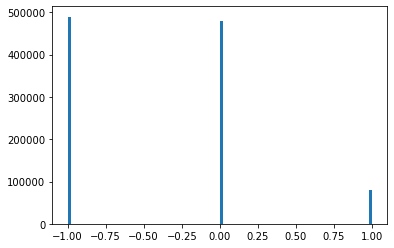

Unique Values: [-1  0  1]


In [24]:
# histogram of data in cloudmask
'''
reminder: 
class one: cloudy
class zero: clear
'''
cloudmask_categorical_flat = cloudmask_categorical_2d.flatten()
print(cloudmask_categorical_flat.shape)

ret_hist = plt.hist(cloudmask_categorical_flat, bins='auto')#, range=(-2,2))
plt.show()

# Get the unique values
unique_values = np.unique(cloudmask_categorical_flat)
print("Unique Values:", unique_values)

In [25]:
# labeling output bin file

out_raw_binary_label = 'nncm_'+POB+".msk"  # this image format supports saving neg- values in image
out_raw_binary_fullpath = os.path.join(output_predict_dir, out_raw_binary_label)

print('output mask: "\n%s"' %out_raw_binary_fullpath)

output mask: "
/Users/ehsanmos/MLP_dataset/cloudmask_lab/predict_test_cloudmask/p71_o87048_b28_april/nncm_P071_O087048_B028.msk"


## save binary file

In [26]:
# flatten array and save as binary raw file on local computer

if (write_nncm_binary==True):
    cloudmask_categorical_2d.flatten().astype(np.int8).tofile(out_raw_binary_fullpath) # write as uint8 to be able to read by atmmodel.c
    print('output at: \n%s' %out_raw_binary_fullpath)

else:
    print('write output is off, change the switch and re-run')

output at: 
/Users/ehsanmos/MLP_dataset/cloudmask_lab/predict_test_cloudmask/p71_o87048_b28_april/nncm_P071_O087048_B028.msk


## plot array and save it

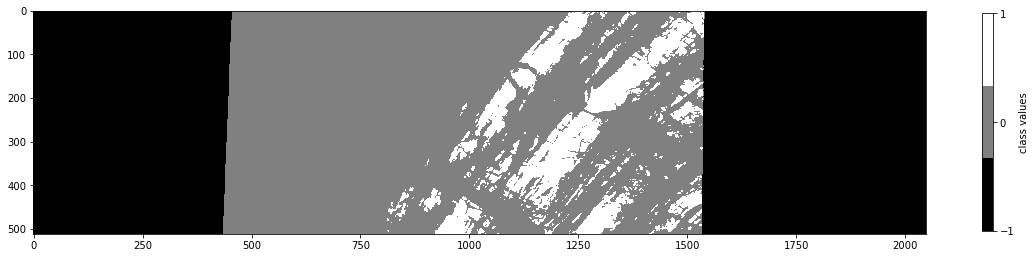

/Users/ehsanmos/MLP_dataset/cloudmask_lab/predict_test_cloudmask/p71_o87048_b28_april/nncm_P071_O087048_B028.png


In [27]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
'''
reminder: 
class one: cloudy
class zero: clear
'''
# Define custom colors for the colormap - incremental from smallest to largest
custom_colors = ['black', 'grey', 'white']

# Create a ListedColormap with the custom colors
cmap = ListedColormap(custom_colors)

# Set up the plot
plt.figure(figsize=(20, 20))  # Adjust the numbers as needed for the desired size

# Plot the array using imshow with the custom colormap
plt.imshow(cloudmask_categorical_2d, cmap=cmap)

# Add a colorbar for reference (optional)
plt.colorbar(ticks=np.unique(cloudmask_categorical_2d), label='class values', pad=.05, shrink=0.2)


if (plot_nncm==True):

    # setup plot dir and name
    plot_name = out_raw_binary_label.split('.')[0]+'.png' 
    plot_fp = os.path.join(plot_dir, plot_name)

    # Save the plot to a file (adjust the filename and format as needed)
    plt.savefig(plot_fp, bbox_inches='tight')  # You can change the format (e.g., 'png', 'pdf', 'svg', etc.)

# Show the plot
plt.show()

print(plot_fp)